In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import csv
from PIL import Image
from PIL.ExifTags import TAGS

#functions
def get_altitude_from_exif(image_path):
    try:
        with Image.open(image_path) as img:
            exif = {TAGS[k]: v for k, v in img._getexif().items() if k in TAGS}
        
        # The exact tag for altitude might vary. You may need to adjust this.
        altitude = exif.get('GPSInfo', {}).get(6, None)
        
        if altitude:
            # Convert altitude to meters if it's not already
            return float(altitude[0]) / float(altitude[1])
    except:
        pass
    return None

def estimate_missing_altitudes(altitudes, max_change_rate=5):
    """
    Estimate missing altitudes using linear interpolation and extrapolation.
    max_change_rate is the maximum allowed change in meters per frame.
    """
    estimated = np.array(altitudes.copy(), dtype=float)
    
    # Forward pass
    last_valid = None
    for i in range(len(estimated)):
        if np.isnan(estimated[i]):
            if last_valid is not None:
                estimated[i] = min(last_valid + max_change_rate, 
                                   estimated[i-1] + max_change_rate if i > 0 else float('inf'))
        else:
            last_valid = estimated[i]
    
    # Backward pass
    last_valid = None
    for i in range(len(estimated)-1, -1, -1):
        if np.isnan(estimated[i]):
            if last_valid is not None:
                estimated[i] = max(last_valid - max_change_rate, 
                                   estimated[i+1] - max_change_rate if i < len(estimated)-1 else 0)
        else:
            last_valid = estimated[i]
    
    # If there are still NaNs, fill with the mean of non-NaN values
    mean_altitude = np.nanmean(estimated)
    estimated[np.isnan(estimated)] = mean_altitude
    
    return estimated

def orb_detector_descriptor(image):
    orb = cv2.ORB_create(nfeatures=2000)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def is_keyframe(current_kp, last_keyframe_kp, min_matches=100):
    if len(last_keyframe_kp) == 0:
        return True
    return len(current_kp) >= min_matches

def refine_E(E, p1, p2, K):
    def objective(E_vec):
        E_mat = E_vec.reshape(3, 3)
        p1_norm = cv2.undistortPoints(p1.reshape(-1, 1, 2), K, None).reshape(-1, 2)
        p2_norm = cv2.undistortPoints(p2.reshape(-1, 1, 2), K, None).reshape(-1, 2)
        error = 0
        for i in range(len(p1_norm)):
            p1_homogeneous = np.append(p1_norm[i], 1)
            p2_homogeneous = np.append(p2_norm[i], 1)
            error += np.abs(np.dot(p2_homogeneous, np.dot(E_mat, p1_homogeneous)))
        return error

    result = minimize(objective, E.flatten(), method='Nelder-Mead')
    return result.x.reshape(3, 3)

def motion_only_bundle_adjustment(R, t, points_3d, points_2d, K):
    def project(points_3d, rvec, tvec, K):
        points_proj, _ = cv2.projectPoints(points_3d, rvec, tvec, K, None)
        return points_proj.reshape(-1, 2)

    def objective(params):
        rvec, tvec = params[:3], params[3:]
        points_proj = project(points_3d, rvec, tvec, K)
        return (points_proj - points_2d).ravel()

    rvec, _ = cv2.Rodrigues(R)
    params = np.hstack((rvec.ravel(), t.ravel()))
    result = least_squares(objective, params)
    
    R_opt, _ = cv2.Rodrigues(result.x[:3])
    t_opt = result.x[3:].reshape(3, 1)
    
    return R_opt, t_opt

def scale_trajectory(trajectory, altitudes):
    """
    Scale the trajectory using known altitudes.
    """
    scaled_trajectory = []
    for i, pose in enumerate(trajectory):
        if i == 0:
            scaled_trajectory.append(np.array([0, 0, altitudes[i]]))
        else:
            scale = altitudes[i] / pose[2] if pose[2] != 0 else 1
            scaled_pose = pose * scale
            scaled_pose[2] = altitudes[i]  # Set Z to the known altitude
            scaled_trajectory.append(scaled_pose)
    return np.array(scaled_trajectory)


Enter the path to the folder containing images:  E:\Shwetabh\testing\VO\camera - Copy


Relative Trajectory (x, y, z):
Pose 0: [0. 0. 0.]
Pose 1: [ 0.14360707 -0.24176713  0.95992018]
Pose 2: [ 0.42300432 -0.39239396  0.55900529]
Pose 3: [ 0.93274402 -0.4203377   0.83282375]
Pose 4: [ 0.17122922  0.02453362 -0.2596529 ]
Pose 5: [0.69902854 0.34180025 0.45852028]
Pose 6: [ 0.24450303 -0.55052745 -0.3427858 ]
Pose 7: [-0.35227288 -0.65062479  0.35987814]
Pose 8: [-0.21598235 -1.02595481  0.68202495]
Pose 9: [-1.35161574 -0.57127859  1.13033329]
Pose 10: [-1.16209544 -1.56957599  0.66474278]
Pose 11: [-1.50717052 -1.3607548  -0.10079063]
Pose 12: [-1.93548952  0.22573948  0.82523252]
Pose 13: [ 0.56177408  2.13200907 -0.15882979]
Pose 14: [ 0.47606857  1.45068824 -0.96819738]
Pose 15: [1.66258687 1.88588082 0.07574571]
Pose 16: [ 2.21812222  2.2783335  -0.67135906]
Pose 17: [-1.59187666 -0.01484729 -4.32772836]
Pose 18: [-1.2994736  -1.91306083 -3.41968083]
Pose 19: [-1.22056276 -1.69020902 -2.53179429]
Pose 20: [-1.12154574 -1.23345865 -1.7706972 ]
Pose 21: [-1.03363401 -1.

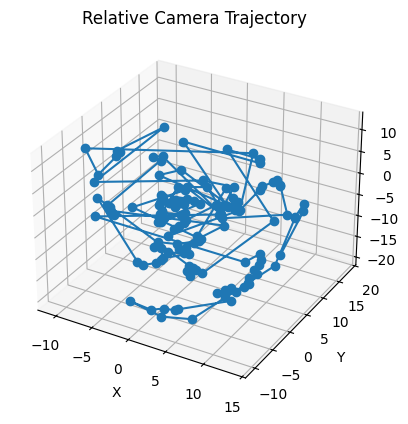

In [8]:
K = np.array([
    [4085.11, 0, 3000],
    [0, 4102.56, 2000],
    [0, 0, 1]
])

#images
image_folder = input("Enter the path to the folder containing images: ")
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')])

images = []
gray_images = []
keypoints = []
descriptors = []

for image_file in image_files:
    img_path = os.path.join(image_folder, image_file)
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    images.append(img)
    gray_images.append(gray_img)
    
    k, d = orb_detector_descriptor(gray_img)
    keypoints.append(k)
    descriptors.append(d)

# FLANN matcher
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Calculate camera trajectory
R_total = np.eye(3)
t_total = np.zeros((3, 1))
trajectory = [t_total.flatten()]

last_keyframe_kp = []
last_keyframe_desc = None
last_keyframe_index = -1

for i in range(1, len(images)):
    if is_keyframe(keypoints[i], last_keyframe_kp):
        if last_keyframe_desc is not None:
            matches = flann.knnMatch(last_keyframe_desc, descriptors[i], k=2)
            good_matches = []
            for m, n in matches:
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)

            if len(good_matches) > 10:
                p1 = np.float32([keypoints[last_keyframe_index][m.queryIdx].pt for m in good_matches])
                p2 = np.float32([keypoints[i][m.trainIdx].pt for m in good_matches])

                E, mask = cv2.findEssentialMat(p1, p2, K, method=cv2.RANSAC, prob=0.999, threshold=0.5)
                E_refined = refine_E(E, p1, p2, K)
                _, R, t, mask = cv2.recoverPose(E_refined, p1, p2, K)

                # Triangulate points
                points_4d = cv2.triangulatePoints(K @ np.hstack((np.eye(3), np.zeros((3, 1)))),
                                                 K @ np.hstack((R, t)),
                                                 p1.T, p2.T)
                points_3d = (points_4d[:3] / points_4d[3]).T

                # Motion-only Bundle Adjustment
                R_opt, t_opt = motion_only_bundle_adjustment(R, t, points_3d, p2, K)

                R_total = R_opt @ R_total
                t_total = R_opt @ t_total + t_opt

                trajectory.append(t_total.flatten())

        last_keyframe_kp = keypoints[i]
        last_keyframe_desc = descriptors[i]
        last_keyframe_index = i

trajectory = np.array(trajectory)

# Print out the trajectory
print("Relative Trajectory (x, y, z):")
for i, position in enumerate(trajectory):
    print(f"Pose {i}: {position}")

# Save trajectory to a CSV file
output_file = "camera_trajectory.csv"
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Pose', 'X', 'Y', 'Z'])  # Header
    for i, position in enumerate(trajectory):
        csv_writer.writerow([i, position[0], position[1], position[2]])

print(f"Trajectory saved to {output_file}")

# Visualize the trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Relative Camera Trajectory')

# Save the plot as an image
plot_file = "camera_trajectory_plot.png"
plt.savefig(plot_file)
print(f"Trajectory plot saved to {plot_file}")

plt.show()

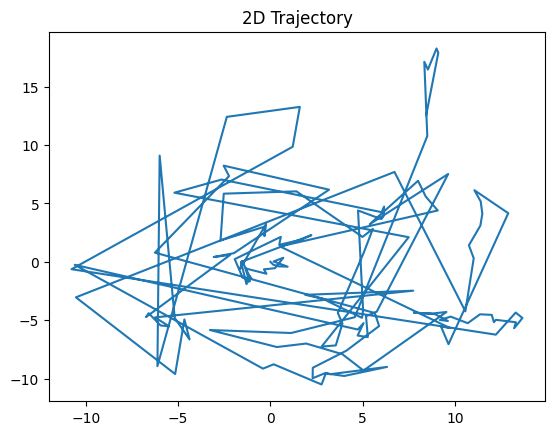

In [9]:
plt.figure()
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.title('2D Trajectory')
plt.show()